# P&D ISSP - Base notebook
@Students: You are free to edit anything you want.

Packages

In [7]:
import os
import matplotlib
import package.general as genfcns
import package.gui_utils as guifcns
matplotlib.style.use('default')  # <-- for notebooks: white figures background

# Root path (path to where you are storing this very notebook)
ROOTPATH = 'C:/Users/uprub/Documents/PandD_git/P-D-ISSP'  #  /!/  Adapt this to your system  /!/ 
pathToSoundFiles = f'{ROOTPATH}/sound_files/'

# Parameters (examples)
speechfilenames = [
    pathToSoundFiles + 'speech1.wav',
    pathToSoundFiles + 'speech2.wav'
]
noisefilenames = [
    pathToSoundFiles + 'Babble_noise1.wav'
]
signalDuration = 10     # [s]

Build acoustic scenario and generate RIRs using GUI

In [2]:
# Launch GUI
guifcns.RIRg_GUI(
    exportFolder=f'{os.getcwd()}/rirs',
    outputRIRplot=False,
    distBwMics=10,  # [cm]
    fs=44100,
    t60=0,
    theme='SystemDefault',
)

[INVALID VALUE] Please enter a room dimension larger than 2 metres.
[INVALID VALUE] Please enter a room dimension larger than 2 metres.
Note that the RIRs are sampled at 44100 Hz.
PyRoomAcoustics is computing the 5 RIRs...
RIRs computed successfully. Saving as Pickle archive.
RIRs saved in file: "rirs_20250218_084017.pkl.gz", in folder
"c:\Users\uprub\Documents\PandD_git\P-D-ISSP\rirs"
You may close the GUI if not needed anymore!


Acoustic scenario object containing the RIRs, with parameters:
>> Field "audioCoords": [[np.float64(4.0), np.float64(6.8999999999999995)]]
>> Field "audioIds": ['64']
>> Field "c": 340
>> Field "distBwMics": 0.05
>> Field "exportFolder": c:\Users\uprub\Documents\PandD_git\P-D-ISSP/rirs
>> Field "fs": 44100
>> Field "lineIds": [1, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57]
>> Field "lineTextIds": [2, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58]
>> Field "micCoords": [[np.float64(8.100000000000001), np.float64(5.5)], [np.float64(8.100000000000001), np.float64(5.550000000000001)], [np.float64(8.100000000000001), np.float64(5.6000000000000005)], [np.float64(8.100000000000001), np.float64(5.6499999999999995)], [np.float64(8.100000000000001), np.float64(5.699999999999999)]]
>> Field "micsIds": ['59', '60', '61', '62', '63']
>> Field "nMicsPerArray": 5
>> Field "noi

RIRs selection

(22050, 5, 1)


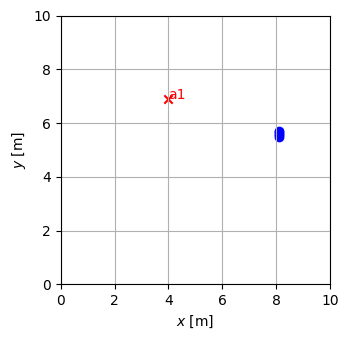

<Figure size 640x480 with 0 Axes>

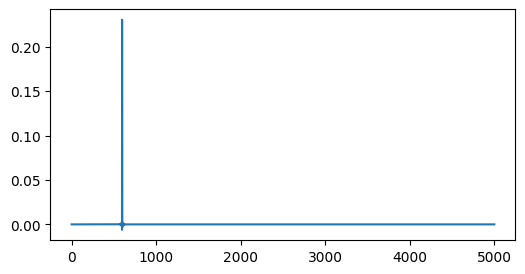

In [8]:
import matplotlib.pyplot as plt
# Select RIRs to be used
# rirFile = 'rirs/'  # use this to input a specific set of RIRs (full path to .pkl.gz file)
rirFile = genfcns.select_latest_rir(path='./rirs/')  # use this to select the lastly generated RIRs
# Load from Pickle archive
acousticScenario = guifcns.load_rirs(path=rirFile)
# >>> NB: the RIRs can be accessed as acousticScenario.RIRsAudio /or/ RIRsNoise
acousticScenario.plot_asc()  # show the acoustic scenario as a pl

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(acousticScenario.RIRsAudio[0:5000,0,0])

# plt.figure()
# plt.figure(figsize=(6, 3))
# plt.plot(acousticScenario.RIRsNoise[:,0,0])
print(acousticScenario.RIRsAudio.shape)
# print(acousticScenario)

# print(acousticScenario.RIRsAudio)
# print(acousticScenario.RIRsNoise.shape)
# print(acousticScenario)


(441000, 5)


<Figure size 640x480 with 0 Axes>

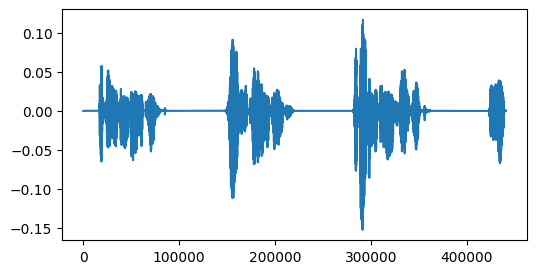

<Figure size 640x480 with 0 Axes>

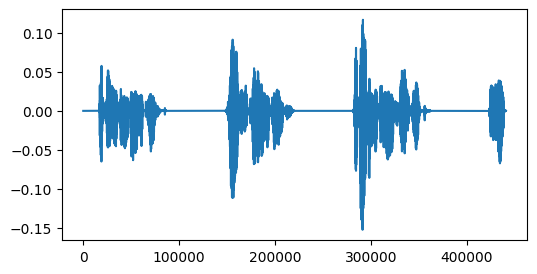

In [14]:
# Part 2
import scipy
import numpy as np
import soundfile as sf
import scipy.signal as signal
import sounddevice as sd

def create_micsigs(audio_name1, audio_name2, noise_name, acousticScenario):
    num_micro = acousticScenario.RIRsAudio.shape[1]   # number of microphones
    num_audio = acousticScenario.RIRsAudio.shape[2]   # number of audio sources
    if acousticScenario.RIRsNoise is None:
        num_noise = 0   # number of noise sources
    else:
        num_noise = acousticScenario.RIRsNoise.shape[2]   # number of noise sources
        RIR_noise1 = acousticScenario.RIRsNoise.squeeze(axis=2)  
      
    fs = acousticScenario.fs    # unit: Hz
    T_ds = int(10*fs)  # unit: s

    if num_audio == 2:
        RIR_audio1, RIR_audio2 = np.dsplit(acousticScenario.RIRsAudio, 2)
        RIR_audio1 = RIR_audio1.squeeze(axis=2)
        RIR_audio2 = RIR_audio2.squeeze(axis=2)
    else:
        RIR_audio1 = acousticScenario.RIRsAudio.squeeze(axis=2)
    
    speech1, sr_speech1 = sf.read(audio_name1)
    speech2, sr_speech2 = sf.read(audio_name2)
    noise1, sr_noise1 = sf.read(noise_name)

    num_samples_speech1 = int(len(speech1) * fs / sr_speech1)
    num_samples_speech2 = int(len(speech2) * fs / sr_speech2)
    num_samples_noise = int(len(noise1) * fs / sr_noise1)
    speech1 = signal.resample(speech1, num_samples_speech1)
    speech2 = signal.resample(speech2, num_samples_speech2)
    noise1 = signal.resample(noise1, num_samples_noise)

    speech1 = speech1[0:T_ds]
    speech2 = speech2[0:T_ds]
    noise1 = noise1[0:T_ds]

    mic1 = []
    mic2 = []

    for i in range(num_micro):
        rec_signal1_tmp = scipy.signal.fftconvolve(speech1, RIR_audio1[:,i])
        if num_audio == 2:
            rec_signal2_tmp = scipy.signal.fftconvolve(speech2, RIR_audio2[:,i])
        else:
            rec_signal2_tmp = np.zeros(rec_signal1_tmp.shape)

        if acousticScenario.RIRsNoise is not None:
            rec_noise_tmp = scipy.signal.fftconvolve(noise1, RIR_noise1[:,i])  
            rec_signal1_tmp = rec_signal1_tmp + rec_noise_tmp

        mic1.append(rec_signal1_tmp)
        mic2.append(rec_signal2_tmp)

    mic1 = np.array(mic1)
    mic2 = np.array(mic2)

    mic = mic1 + mic2    
    mic = mic.T

    return mic[0:T_ds,:], speech1, speech2, noise1, fs


ROOTPATH_sound = "C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files"

mic, speech1, speech2, noise1, fs = create_micsigs(ROOTPATH_sound + '/speech1.wav', ROOTPATH_sound + '/speech2.wav',ROOTPATH_sound + "/Babble_noise1.wav", acousticScenario)

# sd.play(speech1[0:fs*1], fs)
sd.play(mic[:,0], fs)

print(mic.shape)

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(mic[:,0])

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(mic[:,1])


Ground truth TDOA: 0.000045 seconds
Estimated TDOA: 0.000045 seconds


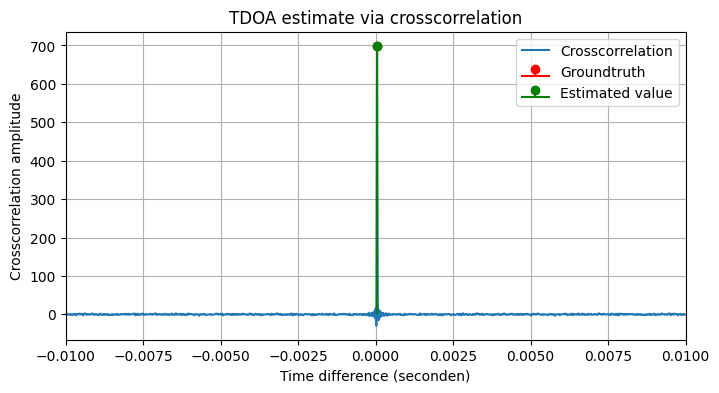

TDOA estimation error: 0.000000 seconds


In [16]:
#Part 3
import numpy as np
import scipy.signal as signal

def TDOA_corr(audio1_name, audio2_name, noise_name, acousticScenario):
  rir1 = acousticScenario.RIRsAudio[:,0,0]
  rir2 = acousticScenario.RIRsAudio[:,1,0]

  direct_path_idx1 = np.argmax(np.abs(rir1))
  direct_path_idx2 = np.argmax(np.abs(rir2))

  ground_truth_TDOA = (direct_path_idx1 - direct_path_idx2) / acousticScenario.fs
  print(f"Ground truth TDOA: {ground_truth_TDOA:.6f} seconds")

  mic_signals, _, _, _, _ = create_micsigs(audio1_name, audio2_name, noise_name, acousticScenario)

  mic1 = mic_signals[:, 0] # Signal of the first mic
  mic2 = mic_signals[:, 1] # Signal of the second mic

  cross_corr = signal.correlate(mic1, mic2, mode="full")
  lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

  estimated_TDOA = lags[np.argmax(cross_corr)] / acousticScenario.fs
  print(f"Estimated TDOA: {estimated_TDOA:.6f} seconds")

  plt.figure(figsize=(8, 4))
  plt.plot(lags / acousticScenario.fs, cross_corr, label="Crosscorrelation")
  plt.stem([ground_truth_TDOA], [np.max(cross_corr)], linefmt="r-", markerfmt="ro", basefmt="r-", label="Groundtruth")
  plt.stem([estimated_TDOA], [np.max(cross_corr)], linefmt="g-", markerfmt="go", basefmt="g-", label="Estimated value")

  plt.xlabel("Time difference (seconden)")
  plt.ylabel("Crosscorrelation amplitude")
  plt.legend()
  plt.title("TDOA estimate via crosscorrelation")
  plt.xlim(-0.01, 0.01)
  plt.grid()
  plt.show()

  # Step 5: Print de fout tussen de schatting en de grondwaarheid
  error = np.abs(estimated_TDOA - ground_truth_TDOA)
  print(f"TDOA estimation error: {error:.6f} seconds")

TDOA_corr(ROOTPATH_sound + '/whitenoise_signal_1.wav',ROOTPATH_sound + '/whitenoise_signal_2.wav',ROOTPATH_sound + "/Babble_noise1.wav", acousticScenario)



In [17]:
#Part 4
def DOA_corr(audio1_name, audio2_name, noise_name, acousticScenario):
  mic_signals, _, _, _, _ = create_micsigs(audio1_name, audio2_name, noise_name, acousticScenario)

  mic1 = mic_signals[:,0] # First mic signal
  mic2 = mic_signals[:,1] # Second mic signal

  cross_corr = signal.correlate(mic1, mic2, mode="full")
  lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

  cross_corr /= np.max(np.abs(cross_corr))
  peaks, properties = signal.find_peaks(cross_corr, height=0.2) # Peaks above 50% of max

  if len(peaks) < 2:
    raise ValueError("Less than 2 peaks found. Cannot estimate exactly 2 DOAs.")
  
  peak_indices = np.argsort(properties["peak_heights"])[-2:] # Get indices of top 2 peaks
  selected_peaks = peaks[peak_indices]

  TDOAestAll = []

  for peak in selected_peaks:
    estimated_TDOA = lags[peak] / acousticScenario.fs
    TDOAestAll.append(estimated_TDOA)

  print(f"First estimated TDOA: {TDOAestAll[0]:.6f} seconds")
  print(f"Second estimated TDOA: {TDOAestAll[1]:.6f} seconds")

  c = 340 # Speed of sound in air (m/s)
  mic_distance = acousticScenario.distBwMics
  TDOAestAll = np.array(TDOAestAll)
  cos_theta = (TDOAestAll * c) / mic_distance # estimated cosine of the angle
  cos_theta = np.clip(cos_theta, -1, 1)
  DOA_estimate = np.arccos(cos_theta) * (180 / np.pi) # Angle in degrees

  print(f"estimated DOA: {DOA_estimate[0]:.2f} degrees")
  print(f"estimated DOA: {DOA_estimate[1]:.2f} degrees")
  
  plt.figure(figsize=(8, 4))
  plt.plot(lags / fs, cross_corr, label="cross correlation")
  plt.axvline(x=estimated_TDOA, color='g', linestyle="--", label=f"TDOA: {estimated_TDOA:.6f}s")

  plt.xlabel("Time difference (seconds)")
  plt.ylabel("Cross correlation amplitude")
  plt.legend()
  plt.xlim(-0.01,0.01)
  plt.title("TDOA and DOA estimation via crosscorrelation")
  plt.grid()
  plt.show()
  

  DOAestAll = DOA_estimate
  DOAestAll = np.array(DOAestAll)
  return DOAestAll

DOAestALL = DOA_corr(ROOTPATH_sound + "/whitenoise_signal_1.wav", ROOTPATH_sound + "/whitenoise_signal_2.wav", ROOTPATH_sound + "/Babble_noise1.wav", acousticScenario)
print(DOAestALL)


ValueError: Less than 2 peaks found. Cannot estimate exactly 2 DOAs.

In [ ]:
# Part 5
def TDOA_corr_2(audio1_name, audio2_name, noise_name, acousticScenario, mic):
 first_source = 0
 second_source = 1
 rir1_1 = acousticScenario.RIRsAudio[:,first_source,0]
 rir2_1 = acousticScenario.RIRsAudio[:,second_source,0]

 direct_path_idx1_1 = np.argmax(np.abs(rir1_1))
 direct_path_idx2_1 = np.argmax(np.abs(rir2_1))

 ground_truth_TDOA_1 = (direct_path_idx1_1 - direct_path_idx2_1) / acousticScenario.fs

 print(f"Ground truth TDOA of source 1: {ground_truth_TDOA_1:.6f} seconds")

 rir1_2 = acousticScenario.RIRsAudio[:,first_source,1]
 rir2_2 = acousticScenario.RIRsAudio[:,second_source,1]

 direct_path_idx1_2 = np.argmax(np.abs(rir1_2))
 direct_path_idx2_2 = np.argmax(np.abs(rir2_2))

 ground_truth_TDOA_2 = (direct_path_idx1_2 - direct_path_idx2_2) / acousticScenario.fs

 print(f"Ground truth TDOA of source 2: {ground_truth_TDOA_2:.6f} seconds")

 mic_signals, _, _, _, _ = create_micsigs(audio1_name, audio2_name, noise_name, acousticScenario)

 mic1 = mic_signals[:, 0] # Signal of the first mic
 mic2 = mic_signals[:, 1] # Signal of the second mic

 cross_corr = signal.correlate(mic1, mic2, mode="full")
 lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

 cross_corr /= np.max(np.abs(cross_corr))
 peaks, properties = signal.find_peaks(cross_corr, height=0.2) # Peaks above 50% of max

 if len(peaks) < 2:
  raise ValueError("Less than 2 peaks found. Cannot estimate exactly 2 DOAs.")

 # Select the two highest peaks
 peak_indices = np.argsort(properties["peak_heights"])[-2:] # Get indices of top 2 peaks
 selected_peaks = peaks[peak_indices]

 TDOAestAll = []

 for peak in selected_peaks:
    estimated_TDOA = lags[peak] / acousticScenario.fs
    TDOAestAll.append(estimated_TDOA)

 estimated_TDOA = lags[np.argmax(cross_corr)] / acousticScenario.fs

 print(f"First estimated TDOA: {TDOAestAll[1]:.6f} seconds")
 print(f"Second estimated TDOA: {TDOAestAll[0]:.6f} seconds")

 c = 340 # Speed of sound in air (m/s)
 mic_distance = acousticScenario.distBwMics
 TDOAestAll = np.array(TDOAestAll)
 cos_theta = (TDOAestAll * c) / mic_distance # estimated cosine of the angle
 cos_theta = np.clip(cos_theta, -1, 1)
 DOA_estimate = np.arccos(cos_theta) * (180 / np.pi) # Angle in degrees

 print(f"estimated DOA: {DOA_estimate[1]:.2f} degrees")
 print(f"estimated DOA: {DOA_estimate[0]:.2f} degrees")

TDOA_corr_2("F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_1.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_2.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario, mic)


In [ ]:
# Part 6
import numpy as np
import soundfile as sf
import scipy.signal as sig
import matplotlib.pyplot as plt
import os
import glob

def create_micsigs_2(rir_files, audio_file):
  # """Generates microphone signals from measured impulse responses."""
  rir_signals = [sf.read(f)[0] for f in rir_files]
  audio, fs_audio = sf.read(audio_file)

  # Ensure sampling rates match
  fs_rir = sf.read(rir_files[0])[1]

  T_ds = int(3*fs_rir)
  audio = audio[0:T_ds]

  if fs_audio != fs_rir:
    audio = sig.resample(audio, int(len(audio) * fs_rir / fs_audio))

  # Convolve with impulse response
  mic_signals = [sig.fftconvolve(audio, rir)[:len(audio)] for rir in rir_signals]

  return np.column_stack(mic_signals), fs_rir

def estimate_tdoa(mic1, mic2, fs):
  """Estimates the time difference of arrival (TDOA) using cross-correlation."""
  # corr = sig.correlate(mic1, mic2, mode='full')
  # delay = sig.correlation_lags(len(mic1),len(mic2), mode='full')
  # tdoa = delay[np.argmax(corr)] / fs
  corr = sig.correlate(mic1, mic2, mode='full')
  delay = np.argmax(corr) - (len(mic1) - 1)
  tdoa = delay / fs

  plt.figure()
  plt.plot(corr)
  plt.title(f"Cross-Correlation (Delay={delay} samples, TDOA={tdoa:.6f} s)")
  plt.show()

  return tdoa

def estimate_doa(tdoa, mic_spacing, c=340):
  """Converts TDOA into a DOA estimate."""
  # theta = np.arccos((tdoa * c) / mic_spacing) * (180 / np.pi)
  cos_theta = (tdoa * c) / mic_spacing
  cos_theta = np.clip(cos_theta, -1, 1)
  theta = np.arccos(cos_theta)*(180/np.pi)
  return theta

# Paths to impulse responses and target audio
rir_path = "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s30"
audio_file = "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\part1_track1_dry.wav"
mic_pairs = [("HMIR_L1.wav", "HMIR_L2.wav"), ("HMIR_R1.wav", "HMIR_R2.wav"), ("HMIR_L1.wav", "HMIR_R1.wav")]

# Process each microphone pair
for mic1_file, mic2_file in mic_pairs:
  mic_files = [os.path.join(rir_path, mic1_file), os.path.join(rir_path, mic2_file)]
  mic_signals, fs = create_micsigs_2(mic_files, audio_file)

  # Estimate TDOA
  tdoa = estimate_tdoa(mic_signals[:, 0], mic_signals[:, 1], fs)

  # Define microphone spacing (1.3 cm for same ear, 21.5 cm for opposite ears)
  # mic_spacing = 0.013 if "L1" in mic1_file and "L2" in mic2_file else 0.215
  mic_spacing = 0.215 if "L1" in mic1_file and "R1" in mic2_file else 0.013

  # Estimate DOA
  doa = estimate_doa(tdoa, mic_spacing)
  print(f"DOA estimate for {mic1_file} & {mic2_file}: {doa:.2f}°")



# Signal processing - Week 2: MUSIC algorithm

In [ ]:
import numpy as np

winLength = 1024 # Window length
nSources = acousticScenario.RIRsAudio.shape[-1]
#nSources = acousticScenario.RIRsAudio.shape[-1] +\
#    acousticScenario.RIRsNoise.shape[-1] # Number of sources
theta = np.arange(0, np.pi, step=np.pi / 360)  # angles to consider

print('Computing DOAs via freq.-domain MUSIC algorithm...')

DOAestAll = DOA_corr(ROOTPATH_sound + "/whitenoise_signal_1.wav",ROOTPATH_sound +  "/whitenoise_signal_2.wav",ROOTPATH_sound +  "/Babble_noise1.wav", acousticScenario)
# DOAestAll = np.zeros(nSources)  # default

print(f'All estimated DOAs: {DOAestAll * 180 / np.pi}')

# ------------------ DOA estimation performance check ------------------
# Automatic selection of the target DOA
DOAest, groundTruthDOAtalkers = genfcns.auto_choice_doa(
    DOAestAll, acousticScenario
)
print(f'Selected estimated DOAs: {np.round(DOAest * 180 / np.pi, 2)}')
print(f'Ground truth DOAs: {np.round(groundTruthDOAtalkers * 180 / np.pi, 2)}')
# Check validity
genfcns.check_plot_tdoas(DOAest, DOAestAll, acousticScenario)
# print(f'Estimate error(s): {np.round((DOAest - groundTruthDOAtalkers) * 180/np.pi, 2)} deg.')
print(f'Estimate error(s): {DOAestAll - np.round(groundTruthDOAtalkers * 180 / np.pi, 2)} deg.')
print(DOAestAll)

print("hello world")

Computing DOAs via freq.-domain MUSIC algorithm...


ValueError: Less than 2 peaks found. Cannot estimate exactly 2 DOAs.

In [ ]:
mic, _, _, _, _ = create_micsigs(ROOTPATH_sound + '/speech1.wav', ROOTPATH_sound + '/speech2.wav',ROOTPATH_sound + "/Babble_noise1.wav", acousticScenario)